In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import pymc3 as pm
import pandas as pd
import os

np.random.seed(123)

%matplotlib inline
plt.style.use('ggplot')

import matplotlib

text_size = 20

matplotlib.rcParams['figure.figsize'] = (15, 10)
matplotlib.rcParams['axes.titlesize'] = text_size
matplotlib.rcParams['axes.labelsize'] = text_size - 2
matplotlib.rcParams['xtick.labelsize'] = text_size - 4
matplotlib.rcParams['ytick.labelsize'] = text_size - 4

/usr/local/lib/python3.4/dist-packages/joblib/_multiprocessing_helpers.py:29: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


# Model regresji liniowej

## $Y \sim \textrm{N} (\mu, \sigma^2)$

## $ \mu = \alpha + \beta_1 X_1 + \beta_2 X_2$

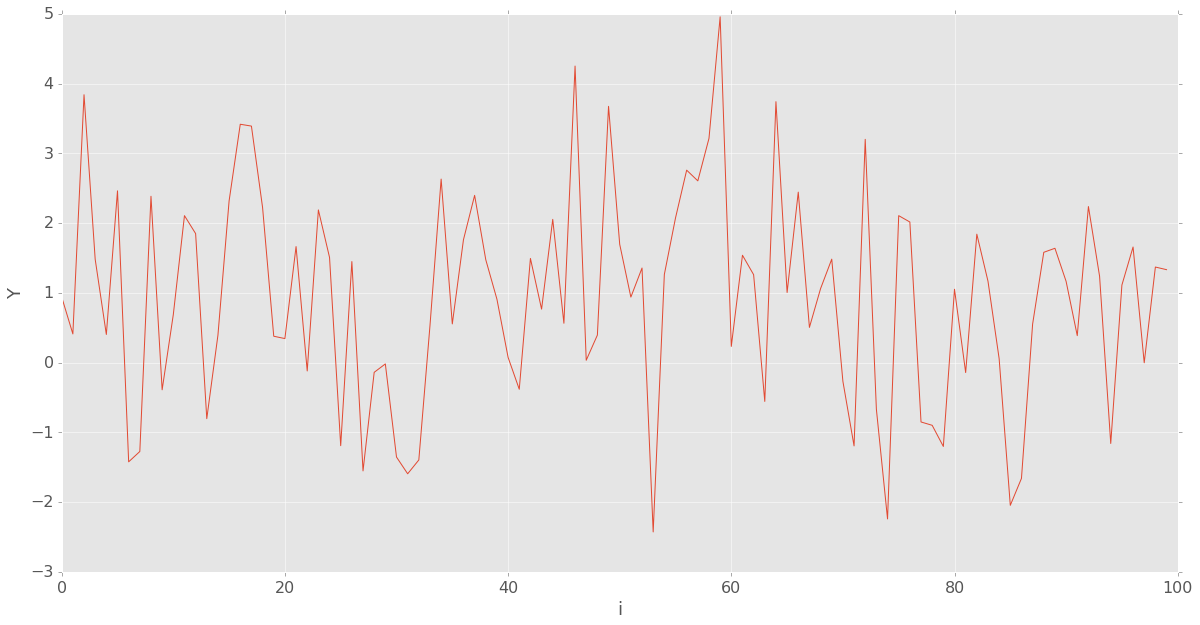

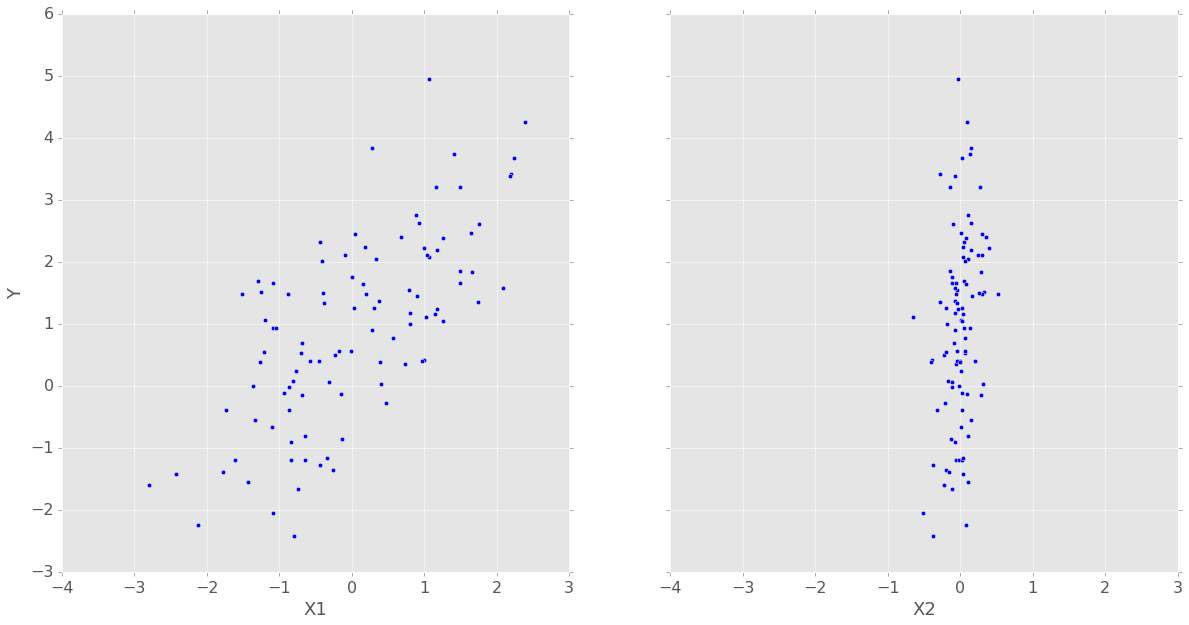

In [2]:
# faktyczne wartosci parametrow
alpha, sigma = 1, 1
beta = [1, 2.5]

size = 100

X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

plt.figure(figsize = (20,10))
plt.plot(Y)
plt.xlabel('i')
plt.ylabel('Y')

fig, axes = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (20, 10))
axes[0].scatter(X1, Y)
axes[0].set_xlabel('X1')
axes[0].set_ylabel('Y')

axes[1].scatter(X2, Y)
axes[1].set_xlabel('X2')

# Definicja modelu

In [3]:
basic_model = pm.Model()

# tworzymy context managera -- wszystko co nastapi w ramach tego bloku 'with'
#  zostanie wziete do tworzenia tego modelu
with basic_model:
    # prajory dla nieznanych parametrow;
    # to sa zmienne losowe o zadanych rozkladach (i definiujacych je parametrach)
    # te parametry (`mu` i `sd`) nosza nazwe "hiperparametry"
    alpha = pm.Normal('alpha', mu = 0, sd = 10)
    beta = pm.Normal('beta', mu = 0, sd = 10, shape = 2) # dostaniemy dwu-elementowa liste bet
    sigma = pm.HalfNormal('sigma', sd = 1)
    
    # wartosc oczekiwana zmiennej objasniajacej (jest to zmienna losowa, zauwaz)
    mu = alpha + beta[0]*X1 + beta[1]*X2
    # zauwaz, ze jest to model DETERMINISTYCZNY, nie ma tu zadnego elementu losowego (poza tym, ktory siedzi w X1, X2 i betach)
    
    # likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu = mu, sd = sigma, observed = Y)
    # tego typu zmienna nosi nazwe "observed stochastic";
    # zauwaz, ze parametry tego rozkladu (mu i sigma) sa zdefiniowanymi wczesniej zmiennymi losowymi 

Applied log-transform to sigma and added transformed sigma_log to model.


# Fitowanie modelu

## zwykły MAP

In [4]:
map_estimate = pm.find_MAP(model = basic_model, fmin = sc.optimize.fmin_powell)

print(map_estimate)

{'alpha': array(0.9090521898978398), 'beta': array([ 0.95140146,  2.61437458]), 'sigma_log_': array(-0.03000977520318259)}


## za pomocą MCMC (a konkretniej, algorytmu NUTS)

In [5]:
N = 10000

with basic_model:
    
    # najpierw znajdujemy porzadne parametry poczatkowe, korzystajac ze zwyklego MAPa
    start = pm.find_MAP(fmin = sc.optimize.fmin_powell)
    # zauwaz, ze jako pierwszy argument (model) zostal przekazany `basic_model`
    
    # ciagniemy N probek a posteriori
    trace = pm.sample(N, start = start)

Assigned NUTS to alpha
Assigned NUTS to beta
Assigned NUTS to sigma_log_
 [-----------------100%-----------------] 10000 of 10000 complete in 7.9 sec

# Wykresy wyników (zmienna `trace`)

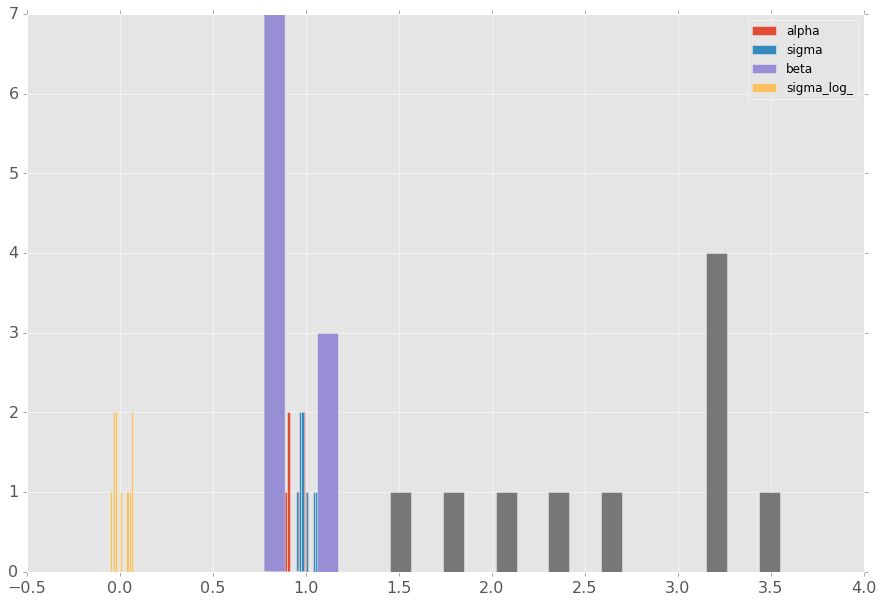

In [6]:
plt.figure(figsize = (15,10))
for parameter_key in trace[0].keys():
    plt.hist(trace[parameter_key][-10:], label = parameter_key)

plt.legend()


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f21703bfda0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f21701ec208>]], dtype=object)

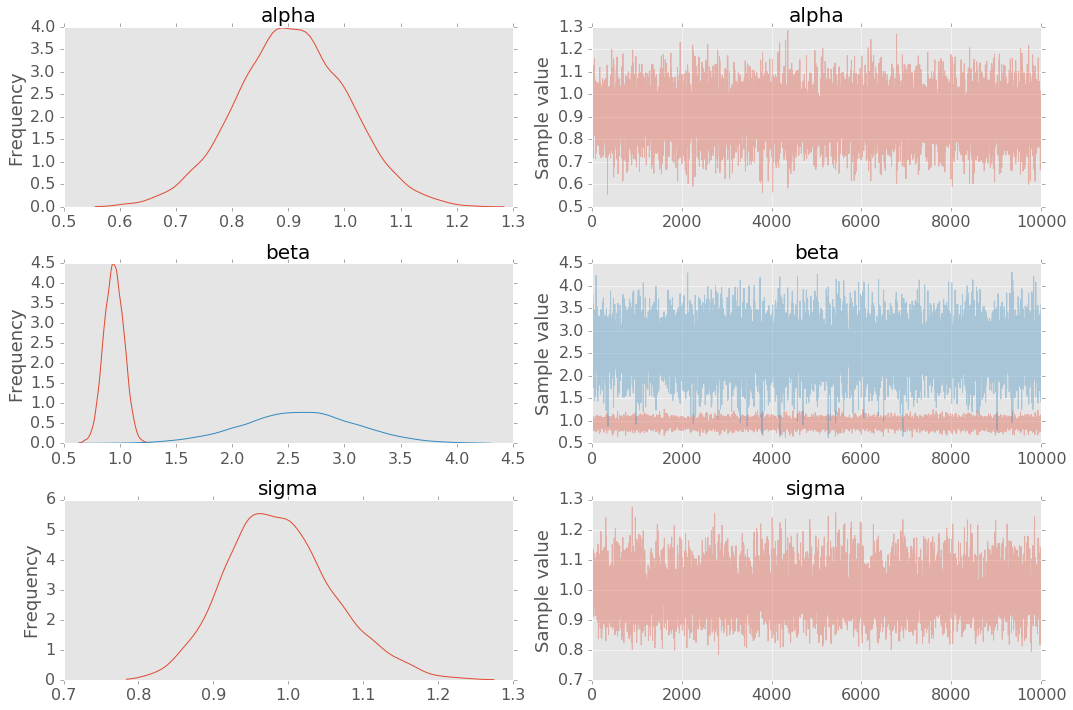

In [7]:
pm.traceplot(trace, figsize = (15, 10))

# Podsumowanie przy użyciu `summary`

In [8]:
pm.summary(trace)


alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.907            0.100            0.001            [0.714, 1.104]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.711          0.840          0.906          0.975          1.102


beta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.948            0.087            0.001            [0.785, 1.122]
  2.601            0.512            0.004            [1.604, 3.616]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.780          0.887          0.947          1.008          1.118
  1.582          2.265          2.605   

## a jakby to wygladalo, gdybysmy wzieli 2x wiecej probek z MCMC?

In [9]:
with basic_model:
    
    # najpierw znajdujemy porzadne parametry poczatkowe, korzystajac ze zwyklego MAPa
    start = pm.find_MAP(fmin = sc.optimize.fmin_powell)
    # zauwaz, ze jako pierwszy argument (model) zostal przekazany `basic_model`
    
    # ciagniemy N probek a posteriori
    trace = pm.sample(2*N, start = start)

pm.summary(trace)

Assigned NUTS to alpha
Assigned NUTS to beta
Assigned NUTS to sigma_log_
 [-----------------100%-----------------] 20000 of 20000 complete in 15.4 sec
alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.908            0.098            0.000            [0.719, 1.101]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.714          0.842          0.908          0.973          1.097


beta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.949            0.088            0.000            [0.778, 1.126]
  2.606            0.512            0.003            [1.642, 3.644]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|=======

# Predykcja

In [10]:
import theano


alpha, sigma = 1, 1
beta = [1, 2.5]

size = 1000

X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# TU JEST COS NOWEGO ###################
X1_shared = theano.shared(X1)
X2_shared = theano.shared(X2)
########################################

Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

# NA TYM BEDZIEMY PREDYKOWAC: #######################################################
X1_new = np.random.randn(size)
X2_new = np.random.randn(size) * 0.2
# A TO BEDZIEMY PROBOWALI ODTWORZYC
Y_new = alpha + beta[0]*X1_new + beta[1]*X2_new + np.random.randn(size)*sigma
######################################################################################

N = 10000

predictive_model = pm.Model()


# tworzymy context managera -- wszystko co nastapi w ramach tego bloku 'with'
#  zostanie wziete do tworzenia tego modelu
with predictive_model:
    # prajory dla nieznanych parametrow;
    # to sa zmienne losowe o zadanych rozkladach (i definiujacych je parametrach)
    # te parametry (`mu` i `sd`) nosza nazwe "hiperparametry"
    alpha = pm.Normal('alpha', mu = 0, sd = 10)
    beta = pm.Normal('beta', mu = 0, sd = 10, shape = 2) # dostaniemy dwu-elementowa liste bet
    sigma = pm.HalfNormal('sigma', sd = 1)
    
    # wartosc oczekiwana zmiennej objasniajacej (jest to zmienna losowa, zauwaz)
    mu = alpha + beta[0]*X1_shared + beta[1]*X2_shared
    # zauwaz, ze jest to model DETERMINISTYCZNY, nie ma tu zadnego elementu losowego (poza tym, ktory siedzi w X1, X2 i betach)
    
    # likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu = mu, sd = sigma, observed = Y)
    # tego typu zmienna nosi nazwe "observed stochastic";
    # zauwaz, ze parametry tego rozkladu (mu i sigma) sa zdefiniowanymi wczesniej zmiennymi losowymi 
    
    # najpierw znajdujemy porzadne parametry poczatkowe, korzystajac ze zwyklego MAPa
    start = pm.find_MAP(fmin = sc.optimize.fmin_powell)
    # zauwaz, ze jako pierwszy argument (model) zostal przekazany `basic_model`
    
    # ciagniemy N probek a posteriori
    trace = pm.sample(N, start = start)
    



Applied log-transform to sigma and added transformed sigma_log to model.
Assigned NUTS to alpha
Assigned NUTS to beta
Assigned NUTS to sigma_log_
 [-----------------100%-----------------] 10000 of 10000 complete in 9.3 sec

In [11]:
X1_shared.set_value(X1_new)
X2_shared.set_value(X2_new)

ppc = pm.sample_ppc(trace, model = predictive_model, samples = 500)

(-4, 6)

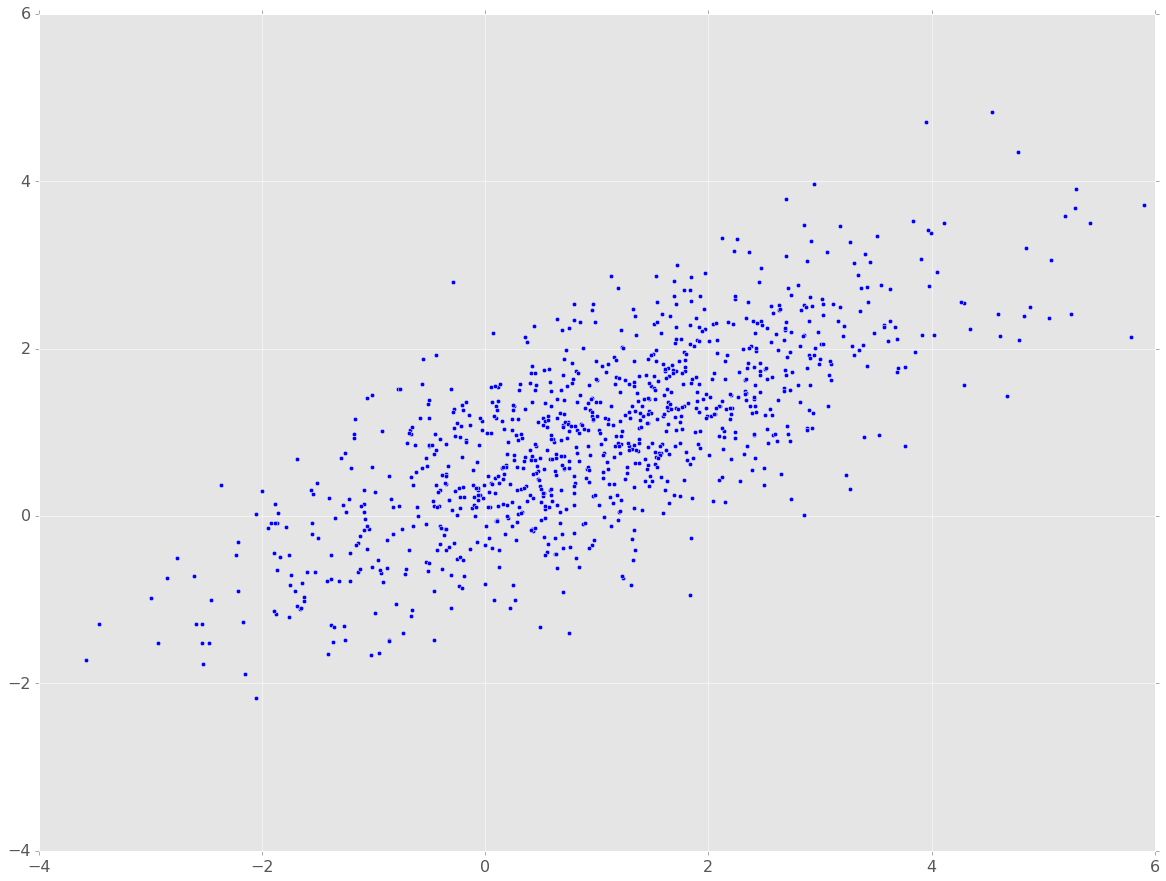

In [12]:
plt.figure(figsize = (20,15))
plt.scatter(Y_new, np.asarray(ppc['Y_obs']).mean(axis = 0))
plt.xlim((-4,6))
plt.ylim((-4,6))

# Case study 1: Stochastic volatility

## Model:

### $\sigma \sim \exp(50) $                               (`Exponential`)

### $\nu \sim \exp(.1)$                                       (`Exponential`)

### $s_i \sim N(s_{i-1}, \sigma^{-2})$ (`GaussianRandomWalk`)

### $\log\left( \frac{y_i}{y_{i-1}}  \right) \equiv r_i \sim t(\nu, 0, \exp(-2s_i))$ (`StudentT`)

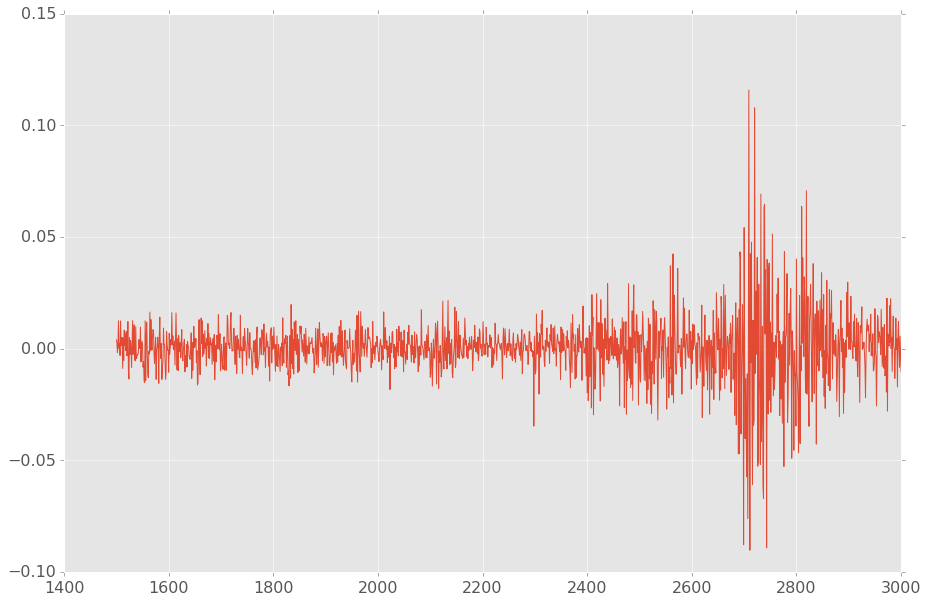

In [13]:
all_returns = pd.read_csv('SP500.csv', parse_dates=True, header = None)


returns = all_returns.loc[1500:3000,] # to nam posluzy do fitowania modelu

plt.plot(returns)

In [14]:
with pm.Model() as sp500_model:

    # zmienna rzadzaca stopniem swobody w rozkladzie t-Studenta
    nu = pm.Exponential('nu', 1./10, testval = 5.)
    # `testval` to (opcjonalna) wartosc poczatkowa 

    # zmienna rzadzaca tym calym "volatility process"
    sigma = pm.Exponential('sigma', 1./.02, testval = .1)

    # random walk o dlugosci `shape`
    s = pm.distributions.timeseries.GaussianRandomWalk('s', sigma**-2, shape = len(returns))

    # zwroc uwage, ze wzielismy `pm.exp` zamiast `np.exp` (`pm.exp` pochodzi z modulu theano)
    volatility_process = pm.Deterministic('volatility_process', pm.exp(-2*s))

    r = pm.StudentT('r', nu, lam = 1/volatility_process, observed = returns)

Applied log-transform to nu and added transformed nu_log to model.
Applied log-transform to sigma and added transformed sigma_log to model.


In [15]:
N = 2000

with sp500_model:
    
    # korzystamy z "Limited-memory BFGS (L-BFGS)", ktory jest lepszy dla wielowymiarowych funkcji,
    # a my mamy ich wszak blisko 3600 (glownie pochodza z `s`)
    start = pm.find_MAP(vars = [s], fmin = sc.optimize.fmin_l_bfgs_b)

    step = pm.NUTS(scaling = start)
    trace = pm.sample(100, step, progressbar = True)

    # Start next run at the last sampled position.
    step = pm.NUTS(scaling = trace[-1], gamma = .25)
    trace = pm.sample(N, step, start = trace[-1], progressbar = True)

 [--                5%                  ] 110 of 2000 complete in 434.1 sec

In [ ]:
pm.traceplot(trace, [nu, sigma])

In [ ]:
fig, ax = plt.subplots(figsize = (20, 15))
returns.plot(ax = ax)
ax.plot(returns.index, 1/np.exp(trace['s',::30].T), 'b', alpha = .075);
ax.set(title = 'volatility_process', xlabel = 'time', ylabel = 'volatility');
ax.legend(['S&P500', 'stochastic volatility process'])